In [1]:
import numpy as np
import secrets
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import itertools
from scipy.optimize import curve_fit
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn.functional as F

In [2]:
# Function cell

def generate_random_binary_string(length):
    binary_string = ''.join(np.random.choice(['0', '1'], size=length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}
    
    if n_tasks > np.power(2, len_taskcode):
        print("Error: n_tasks is too large")
        return False

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = np.random.choice(range(len_message), size=num_checks, replace=False).tolist()
            tasks_dict[binary_string] = integer_list

    return tasks_dict


def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

def generate_dataset_for_task(task_code, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = task_code
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y


In [3]:
# At the moment, only set up to iterate over num_samples

#n_tasks_list = np.arange(1, 10, 1) # number of tasks created. must be less than or equal to 2^len_taskcode.
n_tasks_list = [6]
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 12  # Maximum integer value in the associated integer list
#num_samples_list = np.logspace(start=2, stop=5, num=10, base=10, dtype=int) # number of samples created in the dataset
num_samples_list = np.arange(10000, 20001, 1000)
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate_list = [0.005]
batch_size_list = [32]
num_epochs_list = [200]
test_frac = 0.2 #no iteration
num_layers_list = [6]
#hidden_size_list = np.logspace(start=0, stop=5, num=6, base=2, dtype=int)
hidden_size_list = [32]
#[   1    2    4    8   16   32   64  128  256  512 1024]


def generate_random_binary_string(length):
    binary_string = ''.join(secrets.choice(['0', '1']) for _ in range(length))
    return binary_string

def generate_dict(n_tasks, len_taskcode, num_checks, len_message):
    unique_strings = set()
    tasks_dict = {}

    while len(unique_strings) < n_tasks:
        binary_string = generate_random_binary_string(len_taskcode)

        if binary_string not in unique_strings:
            unique_strings.add(binary_string)

            integer_list = [secrets.randbelow(len_message) for _ in range(num_checks)]
            tasks_dict[binary_string] = integer_list

    return tasks_dict

def generate_dataset(tasks_dict, num_samples):
  data = np.zeros((num_samples, len_taskcode + len_message))
  value = np.zeros(num_samples)
  for i in range(num_samples):
    rand_task = np.random.choice(list(tasks_dict))
    rand_checkbits = tasks_dict[rand_task]
    message = generate_random_binary_string(len_message)
    parity_bit = 0
    for j in rand_checkbits:
      parity_bit += int(message[j])
    parity = parity_bit % 2
    data[i] = np.concatenate((np.array(list(rand_task)), np.array(list(message))))
    value[i] = parity
  return [data, value]

'''
# Define a NN class WITH BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))  # Additional linear layer
        
        #for _ in range(num_layers - 2):
        #    self.layers.append(nn.Linear(hidden_size, hidden_size))
        #    self.layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm1d layer
            
        for i in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
            if batch_size > 1: #for dealing with the edge case where there is only one element of a batch
                self.layers.append(nn.BatchNorm1d(hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            if i == 0:  # Apply ReLU activation only after the additional linear layer
                x = F.relu(layer(x))
            else:
                x = layer(x)
                if i % 2 == 0:
                    if x.shape[0] > 1:  # Apply ReLU and BatchNorm1d if batch size > 1
                        x = F.relu(x)  # Apply ReLU activation after each linear layer
                        x = nn.BatchNorm1d(x.size(1))(x)
                    else:  # Handle case when batch size is 1
                        x = x.squeeze()  # Remove the batch dimension
        x = self.layers[-1](x)
        return x
'''

# IS NOT USING BATCH NORMALISATION
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, num_layers, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        
        for _ in range(num_layers - 2):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        
        x = self.layers[-1](x)
        return x

# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe.iloc[:, :-1].values
        self.target = dataframe.iloc[:, -1].values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.from_numpy(self.data[idx]).float()
        y = torch.tensor(self.target[idx]).float()
        return x, y
    
# For later curve fitting
def sigmoid(x, L ,x0, k, b):
    # L is overll scale, x0 is x translation, b is y translation, k is width
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# For later curve fitting. Assumes that the accuracy goes between 0.5 and 1
def constrained_sigmoid(x, x0, k):
    y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
    return y
    
    
final_train_loss = np.empty(len(hidden_size_list))
final_test_loss = np.empty(len(hidden_size_list))
final_train_accuracy = np.empty(len(hidden_size_list))
final_test_accuracy = np.empty(len(hidden_size_list))
parameter_list = np.empty(len(hidden_size_list))

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(num_samples_list), 2))
test_sig_params = np.zeros((len(num_samples_list), 2))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))
combinations = itertools.product(n_tasks_list, num_samples_list, learning_rate_list, batch_size_list, 
                                 num_epochs_list, num_layers_list, hidden_size_list)
i = 0 #iteration counter
for combination in combinations:
    n_tasks, num_samples, learning_rate, batch_size, num_epochs, num_layers, hidden_size = combination
    print(f'num_samples = {num_samples}')
    tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

    [data, value] = generate_dataset(tasks_dict, num_samples)

    # Create a dataframe for training
    df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

    # Split the data into training and test sets
    #train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)
    train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

    # Create instances of the neural network
    model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

    # Define loss function and optimizer (same as before)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Create DataLoaders for the training and test data
    train_dataset = CustomDataset(train_df)
    test_dataset = CustomDataset(test_df)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    train_loss_list = np.empty(num_epochs)
    test_loss_list = np.empty(num_epochs)

    train_accuracy_list = np.empty(num_epochs)
    test_accuracy_list = np.empty(num_epochs)

    accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

    # Train the model
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        model.train()

        for inputs, labels in train_loader:
            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))

            # Compute predictions
            predictions = (outputs >= 0.5).squeeze().long()

            # Compute accuracy
            train_correct += (predictions == labels).sum().item()
            train_total += labels.size(0)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Calculate average train loss
        train_loss = train_loss / len(train_dataset)
        # Calculate average train accuracy
        train_accuracy = train_correct / train_total

        # Evaluate the model on the test set
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                test_correct += (predictions == labels).sum().item()
                test_total += labels.size(0)

                loss = criterion(outputs, labels.unsqueeze(1))
                test_loss += loss.item() * inputs.size(0)

            # Calculate average test loss
            test_loss = test_loss / len(test_dataset)

        # Calculate average test accuracy
        test_accuracy = test_correct / test_total

        # Update the loss lists
        train_loss_list[epoch] = train_loss
        test_loss_list[epoch] = test_loss

        train_accuracy_list[epoch] = train_accuracy
        test_accuracy_list[epoch] = test_accuracy

    # Creates plots of loss and accuracy
    
    # Create subplots with 1 row and 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    #print(f"Total model parameters = {pytorch_total_params}")

    # Plot the training and test losses on the first subplot
    axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
    axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

    # Plot the training and test accuracies on the second subplot
    axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
    axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')
    
    plt.suptitle(f'{n_tasks} tasks, learning_rate = {learning_rate}, batch_size = {batch_size}, num_epochs = {num_epochs}, num_layers = {num_layers}, hidden_size = {hidden_size}', y=0.98)
    plt.show()
    
    
    # Used when general sigmoid function is being fit
    '''
    # Calculate different sigmoid fits.. Just accuracy for now
    epoch_list = range(1, num_epochs+1)
    p0_train = [max(train_accuracy_list), np.median(epoch_list) , 1 , min(train_accuracy_list)] # this is an mandatory initial guess
    popt_train, pcov_train = curve_fit(sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
    p0_test = [max(test_accuracy_list), np.median(epoch_list) , 1 , min(test_accuracy_list)]
    popt_test, pcov_test = curve_fit(sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')
    
    train_accuracy_fit = sigmoid(epoch_list, popt_train[0], popt_train[1], popt_train[2], popt_train[3])
    test_accuracy_fit = sigmoid(epoch_list, popt_test[0], popt_test[1], popt_test[2], popt_test[3])
    '''

    # Used when constrained sigmoid function is being fit
    epoch_list = range(1, num_epochs+1)
    try:
        p0_train = [np.median(epoch_list) , 1] # this is an mandatory initial guess
        popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
        p0_test = [np.median(epoch_list) , 1]
        popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')
    
        train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1])
        test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1])

        plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
        plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
        plt.legend()
        plt.show()
        
        train_sig_params[i] = popt_train
        test_sig_params[i] = popt_test
        
    except RuntimeError:
        print('Failed to find optimal solution')
    i += 1
    
print(train_sig_params) # x0, k
print(test_sig_params)



num_samples = 10000


  0%|          | 1/200 [00:02<06:48,  2.05s/it]


KeyboardInterrupt: 

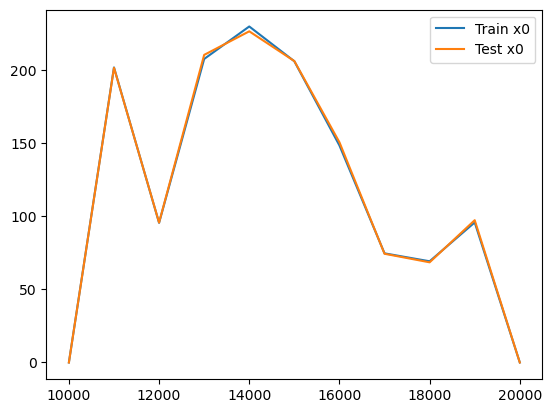

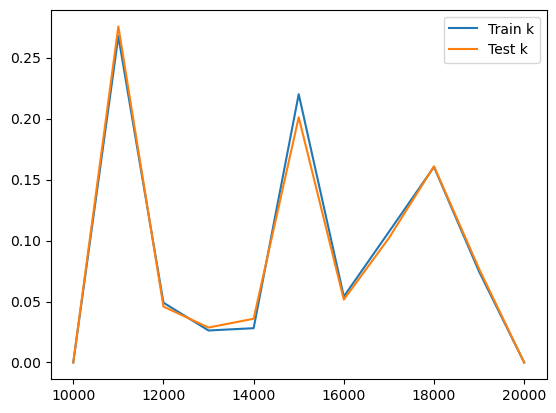

In [63]:
# Plotting sig params. Note that all of these curves are for ACCURACY 

def extract_params(params_list):
    params_list_flattened = params_list.flatten()
    x0 = np.empty(int(len(params_list_flattened) / 2))
    k = np.empty(int(len(params_list_flattened) / 2))
    for i in range(int(len(params_list_flattened) / 2)):
        x0[i] = params_list_flattened[2*i]
        k[i] = params_list_flattened[2*i + 1]
    return [x0, k]

#param_list = np.logspace(start=2, stop=3.2, num=15, base=10, dtype=int) #num_samples_list
param_list = num_samples_list

[train_x0, train_k] = extract_params(train_sig_params)
[test_x0, test_k] = extract_params(test_sig_params)

plt.plot(param_list, train_x0, label='Train x0') 
plt.plot(param_list, test_x0, label='Test x0')
plt.legend()
plt.show()

plt.plot(param_list, train_k, label='Train k')
plt.plot(param_list, test_k, label='Test k')
plt.legend()
plt.show()

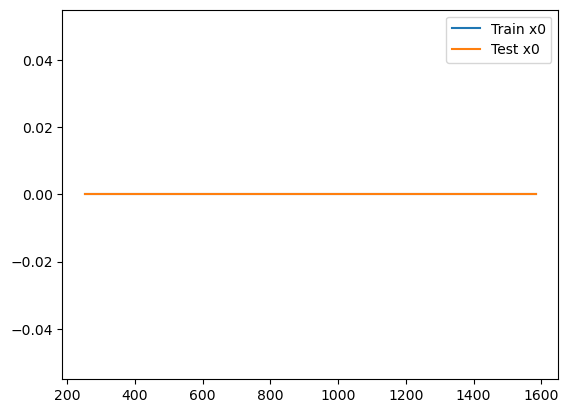

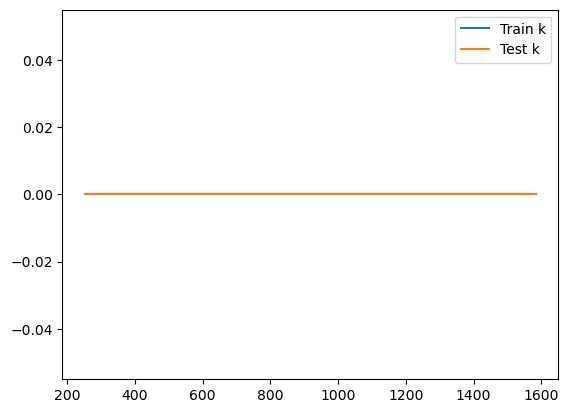

In [42]:
# Plots of sections of the parameter lists. Useful to remove fluctuations at extreme values

start=50
end=1500

def extract_params(params_list):
    params_list_flattened = params_list.flatten()
    x0 = np.empty(int(len(params_list_flattened) / 2))
    k = np.empty(int(len(params_list_flattened) / 2))
    for i in range(int(len(params_list_flattened) / 2)):
        x0[i] = params_list_flattened[2*i]
        k[i] = params_list_flattened[2*i + 1]
    return [x0, k]

new_param_list = param_list[start:end]

[train_x0, train_k] = extract_params(train_sig_params)
[test_x0, test_k] = extract_params(test_sig_params)

new_train_x0 = train_x0[start:end]
new_test_x0 = test_x0[start:end]
new_train_k = train_k[start:end]
new_test_k = test_k[start:end]

plt.plot(new_param_list, new_train_x0, label='Train x0') 
plt.plot(new_param_list, new_test_x0, label='Test x0')
plt.legend()
plt.show()

plt.plot(new_param_list, new_train_k, label='Train k')
plt.plot(new_param_list, new_test_k, label='Test k')
plt.legend()
plt.show()

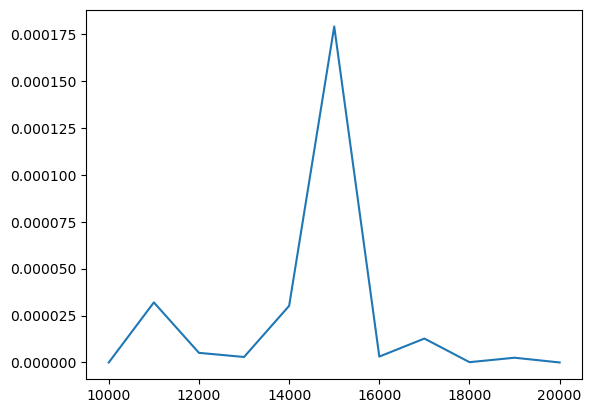

In [65]:
# Calculating the grok gap from sigmoid parameters

def inv_constrained_sig(k, x0, sigma):
    x = -1/k * np.log(1 / (2 * sigma - 1) - 1) + x0
    return x

def grok_gap_squared(params1, params2): 
    # params1 is the test and params2 is the train. Not relevant now, might matter when other complex measures are used
    k1, x01 = params1
    k2, x02 = params2
    deltax = x02 - x01
    if k1==0 or k2==0:
        return 0
    deltainvk = 1/k1 - 1/k2
    gap = 0.5 * np.power(deltax, 2) + np.power(np.pi, 2)/6 * np.power(deltainvk, 2)
    return gap

# Each list entry is a pair of x0 then k
# Designed to deal with lists of the form of train_sig_params and test_sig_params
def find_gaps(train_sig_params, test_sig_params):
    if len(train_sig_params) != len(test_sig_params):
        print("Error: Train and test parameter lists must be of the same length.")
        return
    grok_gap_list = np.zeros(len(train_sig_params))
    for i in range(len(train_sig_params)):
        train_pair = train_sig_params[i]
        test_pair = test_sig_params[i]
        gap = grok_gap_squared(test_pair, train_pair)
        grok_gap_list[i] = gap
    return grok_gap_list

#print(train_sig_params)
#print(test_sig_params)

grok_gap_list = find_gaps(train_sig_params, test_sig_params)
num_samples_list = np.arange(10000, 20001, 1000)
plt.plot(num_samples_list, grok_gap_list)
# Note: I think that I may have to scale this gap by some parameter representing the range of epochs considered? 
# These values just seem way way too small

num_samples = 500


100%|██████████| 4000/4000 [03:58<00:00, 16.74it/s]


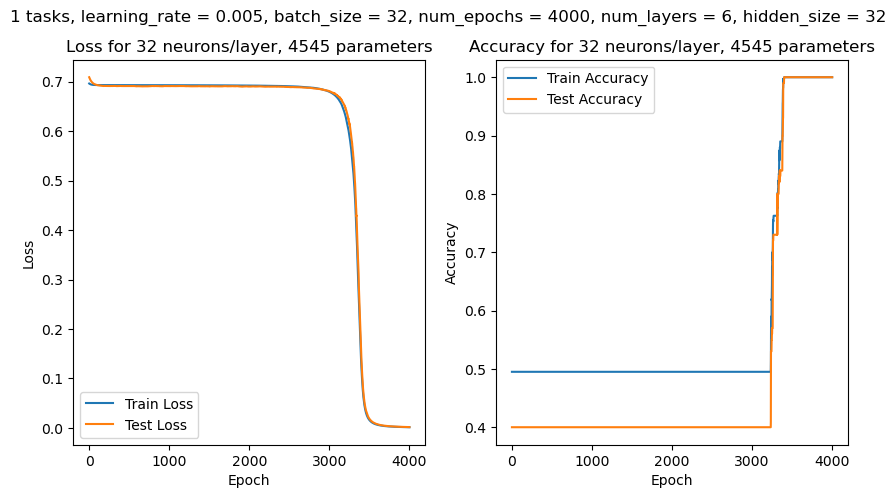

C:\Users\plogo\AppData\Local\Temp\ipykernel_13132\2544603594.py:135: RuntimeWarning: overflow encountered in exp
  y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
100%|██████████| 4000/4000 [03:49<00:00, 17.44it/s]


num_samples = 501


100%|██████████| 4000/4000 [03:18<00:00, 20.10it/s]


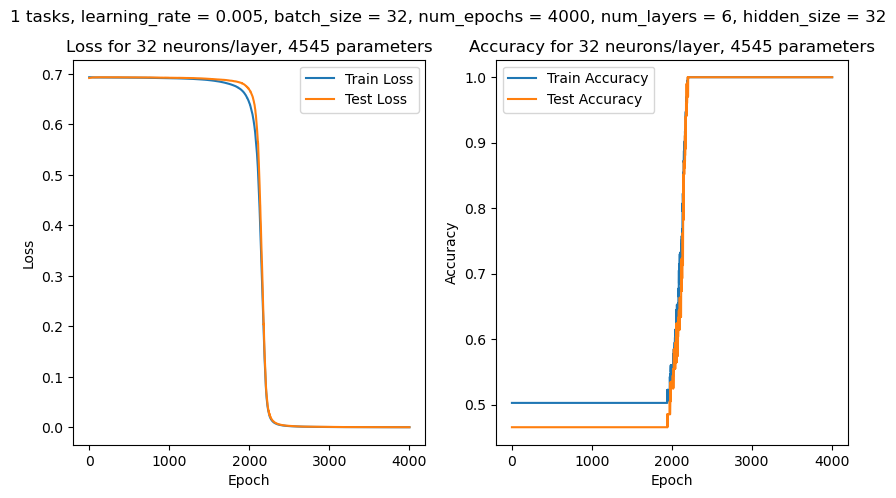

100%|██████████| 4000/4000 [03:32<00:00, 18.79it/s]


train_sig_params =  [[[3.29511299e+03 5.86851300e+02]
  [2.59859594e-02 1.83192291e+00]]

 [[2.10669272e+03 2.70894878e+03]
  [2.53451646e-02 1.16831169e-02]]]
test_sig_params =  [[[3.68442719e+03 5.86498812e+02]
  [4.13541296e-03 3.30798129e+00]]

 [[2.12482563e+03 2.68475421e+03]
  [3.12874744e-02 3.71096792e-02]]]


In [123]:
# Find sigmoid fit parameters on average (weighted by covariance error?)

num_repeats = 2

n_tasks = 1
len_taskcode = 2 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 6  # Maximum integer value in the associated integer list
num_samples_list = np.arange(500, 502, 1)
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32
num_epochs = 4000
test_frac = 0.2 # proportion of dataset reserved for validation
num_layers = 6
hidden_size = 32

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(num_samples_list), 2, num_repeats))
test_sig_params = np.zeros((len(num_samples_list), 2, num_repeats))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))


for index, num_samples in enumerate(num_samples_list):
    print(f'num_samples = {num_samples}')
    
    for repeat_idx in range(num_repeats):
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

        # Create instances of the neural network
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_loss_list = np.empty(num_epochs)
        test_loss_list = np.empty(num_epochs)

        train_accuracy_list = np.empty(num_epochs)
        test_accuracy_list = np.empty(num_epochs)

        accuracy_array = np.zeros((n_tasks, num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        for epoch in tqdm(range(num_epochs)):
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            # Evaluate the model on the test set
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    # Compute predictions
                    predictions = (outputs >= 0.5).squeeze().long()

                    # Compute accuracy
                    test_correct += (predictions == labels).sum().item()
                    test_total += labels.size(0)

                    loss = criterion(outputs, labels.unsqueeze(1))
                    test_loss += loss.item() * inputs.size(0)

                # Calculate average test loss
                test_loss = test_loss / len(test_dataset)

            # Calculate average test accuracy
            test_accuracy = test_correct / test_total

            # Update the loss lists
            train_loss_list[epoch] = train_loss
            test_loss_list[epoch] = test_loss

            train_accuracy_list[epoch] = train_accuracy
            test_accuracy_list[epoch] = test_accuracy
            
        if repeat_idx == 0:
            # Create subplots with 1 row and 2 columns
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            pytorch_total_params = sum(p.numel() for p in model.parameters())
            #print(f"Total model parameters = {pytorch_total_params}")

            # Plot the training and test losses on the first subplot
            axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
            axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].legend()
            axs[0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

            # Plot the training and test accuracies on the second subplot
            axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
            axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Accuracy')
            axs[1].legend()
            axs[1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')

            plt.suptitle(f'{n_tasks} tasks, learning_rate = {learning_rate}, batch_size = {batch_size}, num_epochs = {num_epochs}, num_layers = {num_layers}, hidden_size = {hidden_size}', y=0.98)
            plt.show()

        # Used when constrained sigmoid function is being fit
        epoch_list = range(1, num_epochs+1)
        try:
            p0_train = [np.median(epoch_list) , 1] # this is an mandatory initial guess
            popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
            p0_test = [np.median(epoch_list) , 1]
            popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')

            train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1])
            test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1])

            #plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
            #plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
            #plt.legend()
            #plt.show()

            train_sig_params[index, :, repeat_idx] = popt_train
            test_sig_params[index, :, repeat_idx] = popt_test

        except RuntimeError:
            print('Failed to find optimal solution')
    
print('train_sig_params = ', train_sig_params) # x0, k
print('test_sig_params = ', test_sig_params) # x0, k

In [118]:
train_sig_params_copy = train_sig_params
test_sig_params_copy = test_sig_params

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

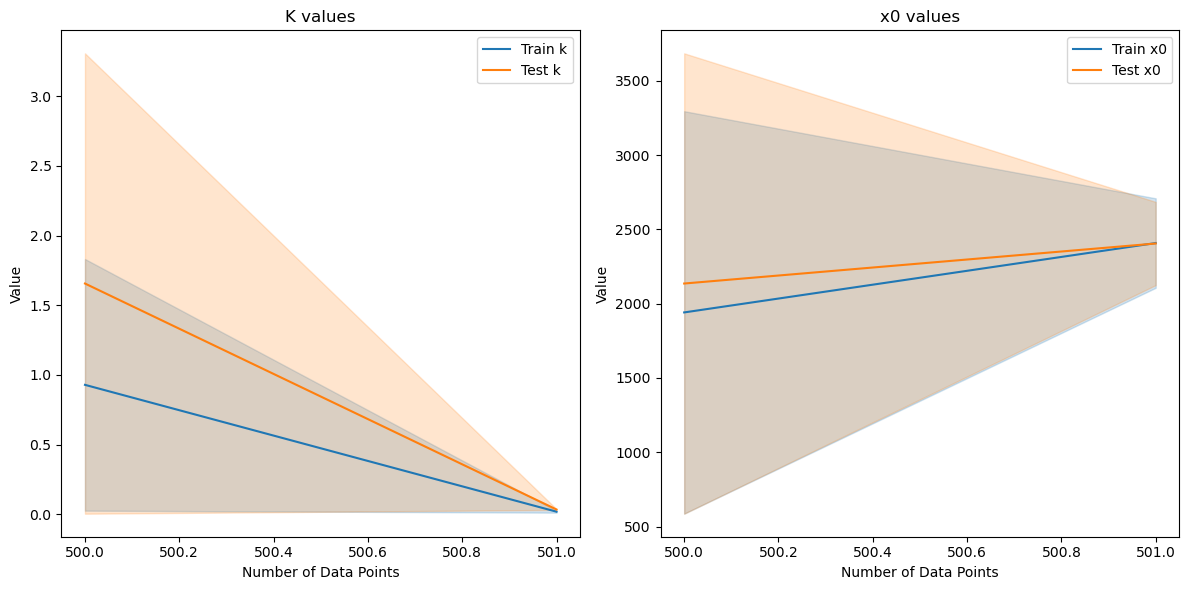

In [124]:
# Try plotting while removing all zero values. 
# This works as when producing a fit fails, the default value for both parameters is 0
# I am not sure whether the repeat function is working.

train_sig_params[ train_sig_params==0.0 ] = np.nan
test_sig_params[ test_sig_params==0.0 ] = np.nan

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

#num_samples_list = np.arange(1000, 2000, 10)
repeated_num_samples_list = np.repeat(num_samples_list, repeats = num_repeats)
#print(num_samples_list)
#print(repeated_num_samples_list)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

train_sig_params_k_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'train_sig_params_k': train_sig_params_k})
test_sig_params_k_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'test_sig_params_k': test_sig_params_k})

# Plot train values
sns.lineplot(data=train_sig_params_k_df, x='repeated_num_samples_list', y='train_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Train k')
sns.lineplot(data=test_sig_params_k_df, x='repeated_num_samples_list', y='test_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Test k')

#sns.lineplot(data=train_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Train k'))
#sns.lineplot(data=test_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Test k')

#axs[0].set_xticks(range(len(num_samples_list)))
#axs[0].set_xticklabels(num_samples_list)
axs[0].set_xlabel('Number of Data Points')
axs[0].set_ylabel('Value')
axs[0].set_title('K values')
axs[0].legend()

train_sig_params_x0_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'train_sig_params_x0': train_sig_params_x0})
test_sig_params_x0_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'test_sig_params_x0': test_sig_params_x0})

# Plot test values
sns.lineplot(data=train_sig_params_x0_df, x='repeated_num_samples_list', y='train_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Train x0')
sns.lineplot(data=test_sig_params_x0_df, x='repeated_num_samples_list', y='test_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Test x0')

#sns.lineplot(data=train_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Train x0')
#sns.lineplot(data=test_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Test x0')

#axs[1].set_xticks(range(len(num_samples_list)))
#axs[1].set_xticklabels(num_samples_list)
axs[1].set_xlabel('Number of Data Points')
axs[1].set_ylabel('Value')
axs[1].set_title('x0 values')
axs[1].legend()

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()

num_samples = 501


 25%|██▍       | 2467/10000 [01:51<05:39, 22.20it/s]


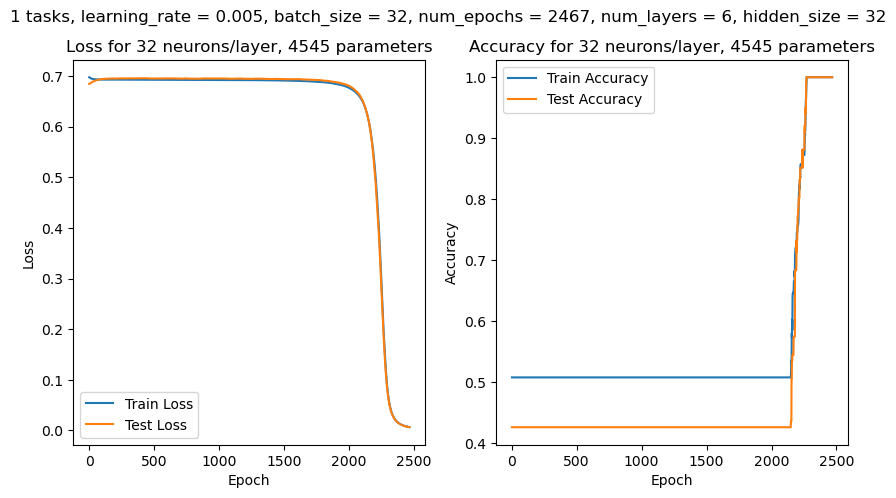

C:\Users\plogo\AppData\Local\Temp\ipykernel_13132\2544603594.py:135: RuntimeWarning: overflow encountered in exp
  y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5
  7%|▋         | 666/10000 [00:42<09:49, 15.84it/s]


Failed to find optimal solution


  6%|▋         | 638/10000 [00:35<08:36, 18.13it/s]


num_samples = 544


  7%|▋         | 696/10000 [00:40<09:04, 17.07it/s]


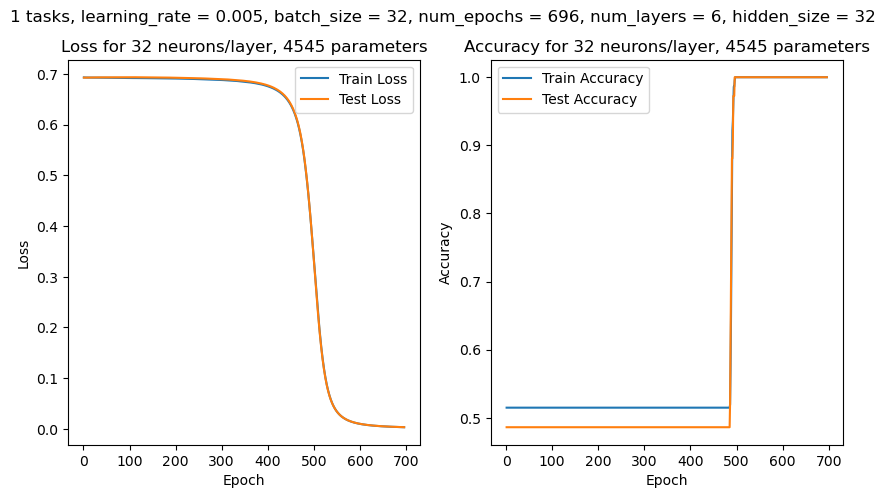

 29%|██▊       | 2851/10000 [03:08<07:52, 15.13it/s]  


num_samples = 590


 20%|█▉        | 1950/10000 [02:05<08:38, 15.54it/s]  


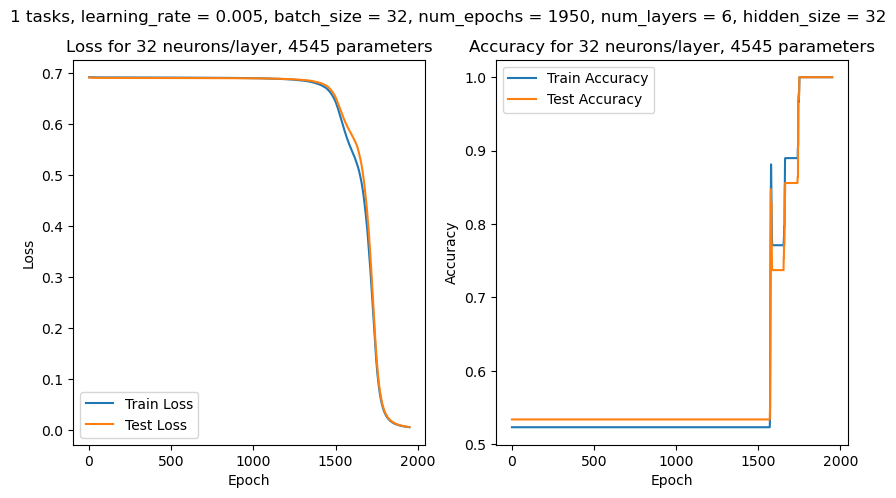

  4%|▍         | 422/10000 [00:26<10:01, 15.94it/s]


num_samples = 641


  7%|▋         | 660/10000 [00:46<10:59, 14.16it/s]


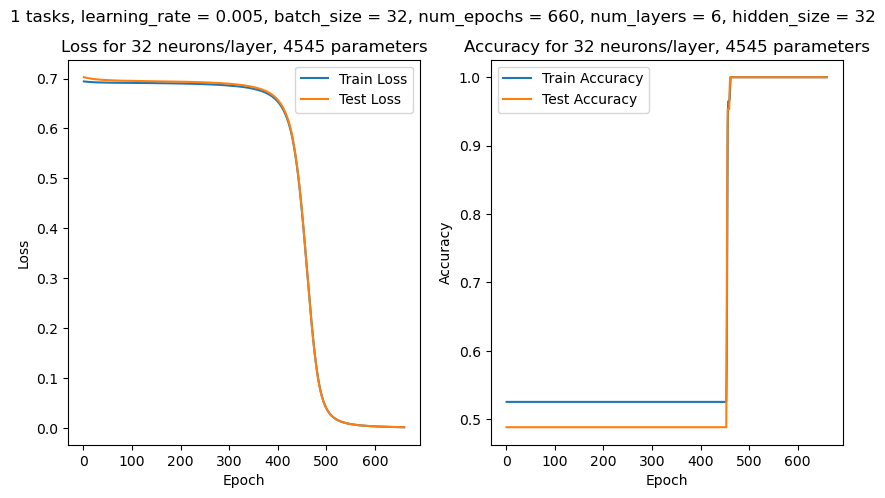

  5%|▌         | 514/10000 [00:36<11:13, 14.09it/s]


Failed to find optimal solution


 23%|██▎       | 2295/10000 [02:39<08:54, 14.43it/s]


num_samples = 696


 12%|█▏        | 1242/10000 [01:39<11:44, 12.42it/s]


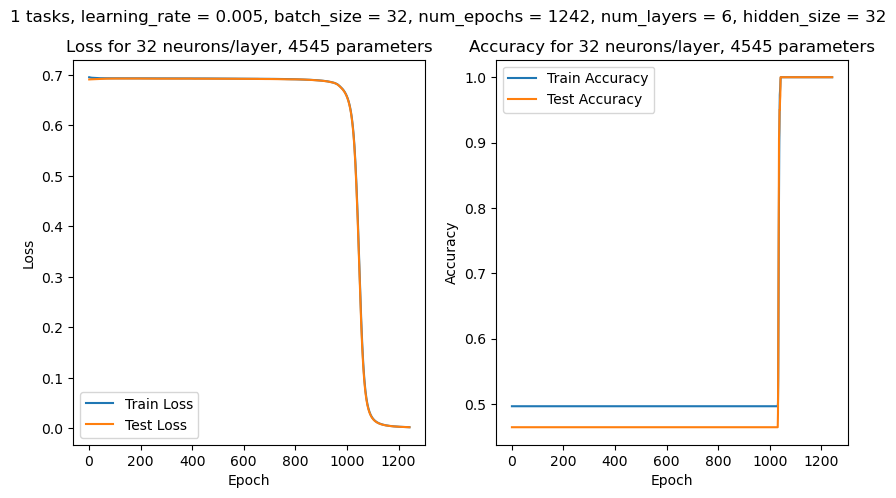

 19%|█▊        | 1851/10000 [01:52<08:15, 16.45it/s]


num_samples = 756


 24%|██▍       | 2444/10000 [03:35<11:04, 11.36it/s]  


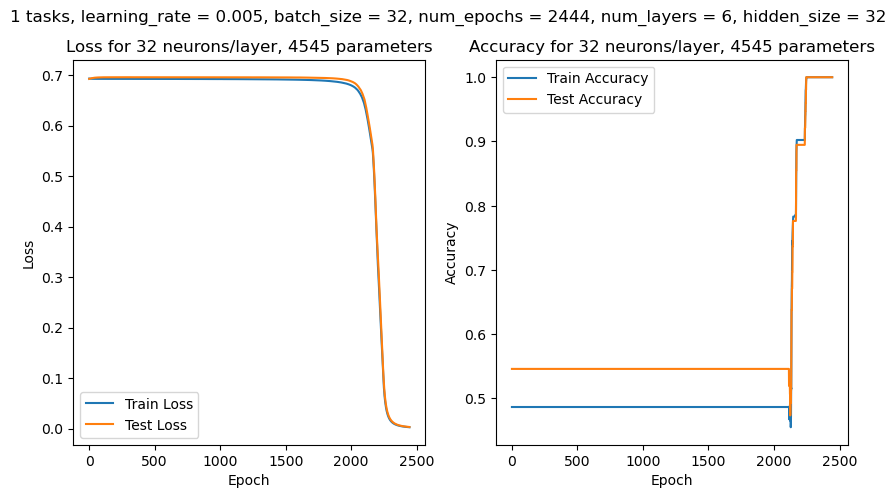

 25%|██▌       | 2503/10000 [04:00<12:00, 10.41it/s]  


num_samples = 820


 22%|██▏       | 2200/10000 [03:52<13:45,  9.45it/s] 


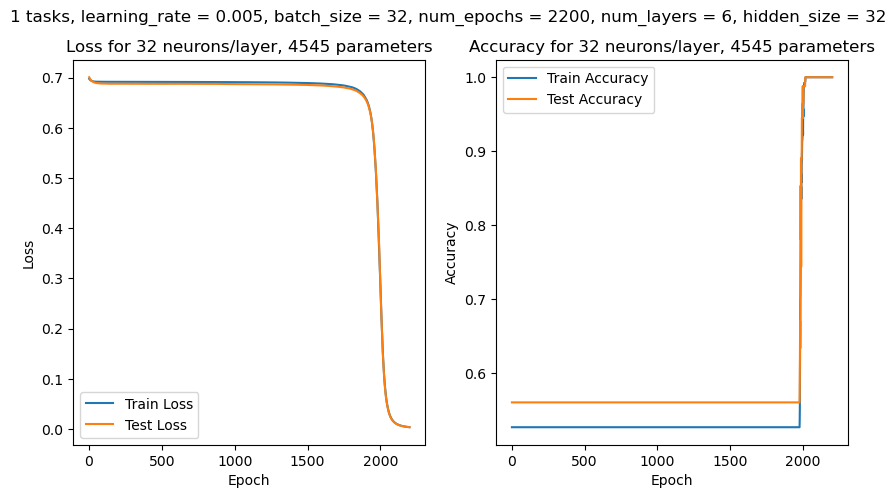

  4%|▍         | 388/10000 [00:40<16:51,  9.50it/s] 


num_samples = 891


 23%|██▎       | 2254/10000 [03:56<13:31,  9.54it/s] 


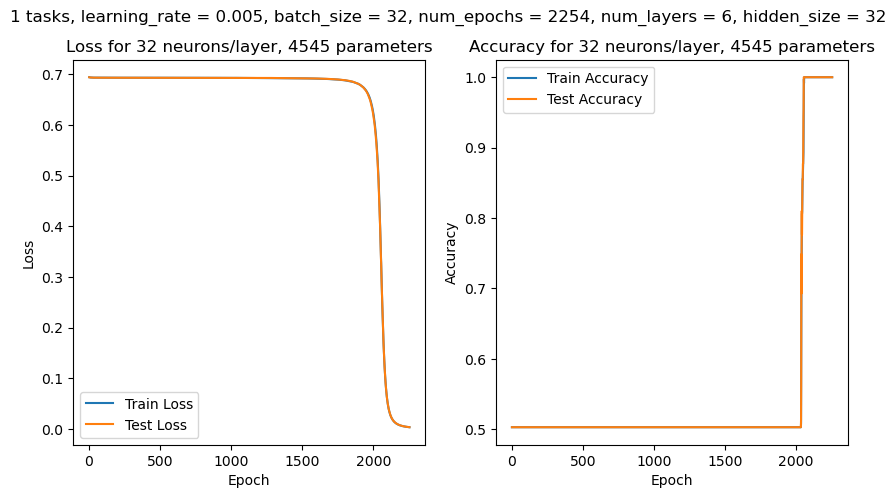

 15%|█▌        | 1542/10000 [02:54<15:56,  8.85it/s] 


Failed to find optimal solution


  4%|▎         | 367/10000 [00:44<19:18,  8.31it/s]


Failed to find optimal solution


 15%|█▌        | 1539/10000 [03:02<16:44,  8.43it/s]  


num_samples = 967


 10%|█         | 1010/10000 [01:47<16:00,  9.36it/s]


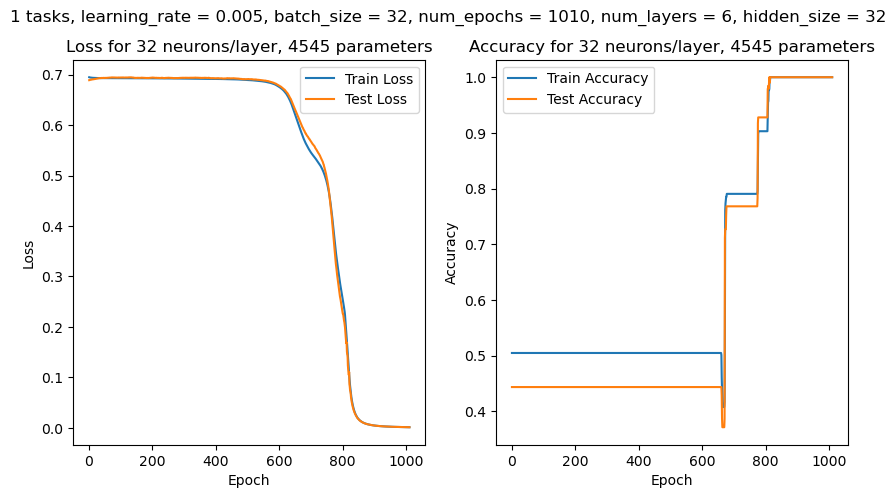

  7%|▋         | 659/10000 [01:11<16:49,  9.25it/s]


num_samples = 1050


  5%|▍         | 469/10000 [00:53<17:57,  8.85it/s]


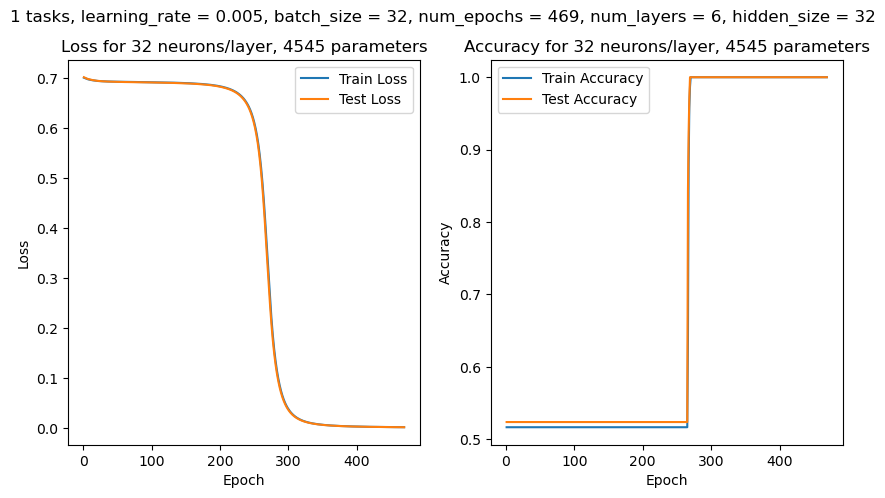

 12%|█▏        | 1160/10000 [03:38<27:44,  5.31it/s] 


num_samples = 1140


  4%|▎         | 356/10000 [01:11<32:17,  4.98it/s]  


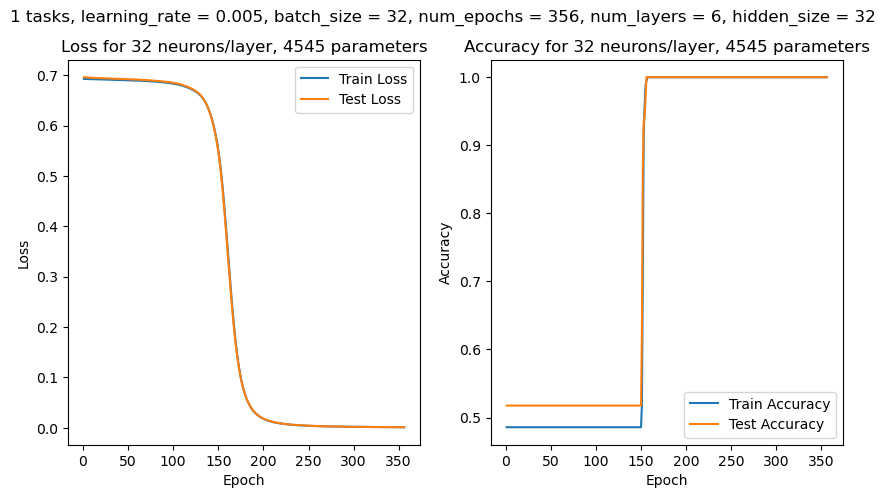

 15%|█▍        | 1475/10000 [03:26<19:50,  7.16it/s] 


num_samples = 1238


  3%|▎         | 324/10000 [00:40<20:02,  8.04it/s]


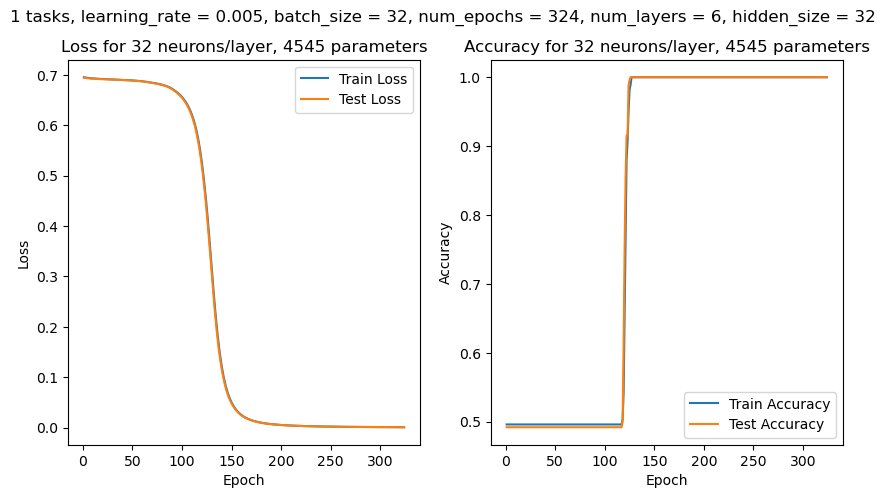

 13%|█▎        | 1316/10000 [02:38<17:23,  8.32it/s]


num_samples = 1344


  4%|▎         | 353/10000 [00:51<23:14,  6.92it/s]


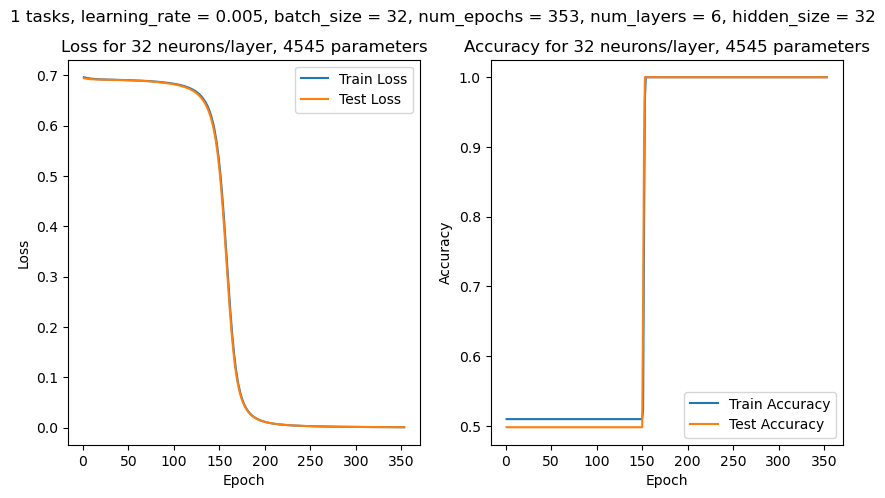

 13%|█▎        | 1341/10000 [02:57<19:03,  7.57it/s]


num_samples = 1459


 13%|█▎        | 1302/10000 [03:07<20:52,  6.94it/s]


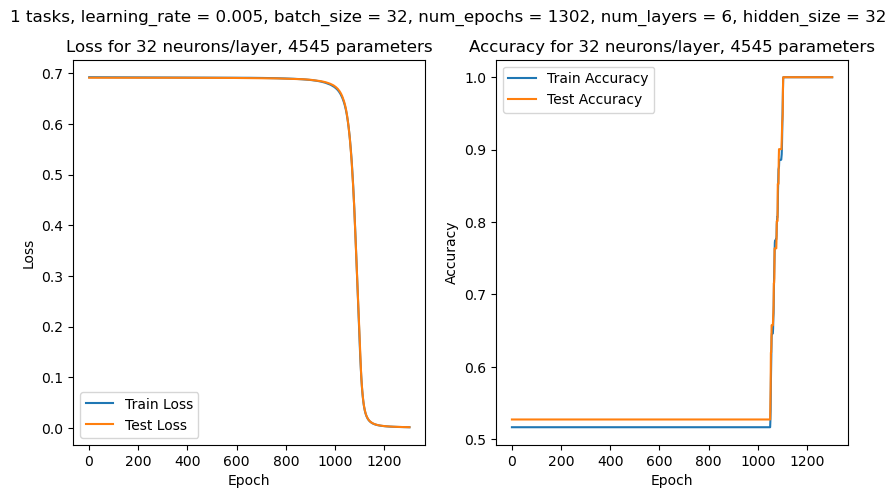

  4%|▎         | 351/10000 [00:53<24:44,  6.50it/s]


Failed to find optimal solution


  3%|▎         | 341/10000 [00:47<22:34,  7.13it/s]


num_samples = 1584


 12%|█▏        | 1242/10000 [03:05<21:47,  6.70it/s]


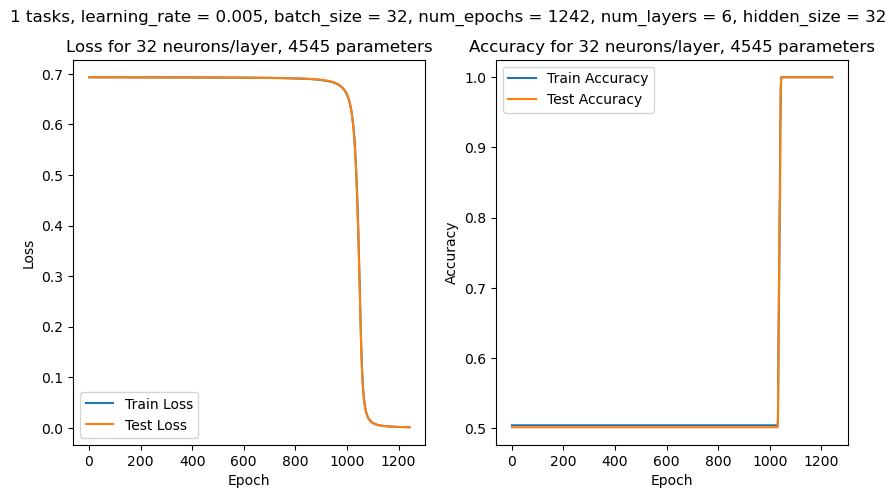

  4%|▎         | 370/10000 [01:25<37:02,  4.33it/s]  


train_sig_params =  [[[2.20112319e+03 3.14416935e+03 2.27784763e+03 2.44180392e+03
   2.72180415e+03 7.72380400e+02 3.48664268e+03 3.28599999e+02
   1.32665656e+03 0.00000000e+00 2.43239474e+03 2.73267159e+02
   3.14856374e+02 4.35120516e+02 4.29741323e+02]
  [3.59153328e-02 5.98350630e-02 6.93405162e-02 3.42450598e-02
   1.73262994e-02 5.84117809e-01 9.36445361e-03 1.67878686e+00
   1.51839530e-02 0.00000000e+00 1.44401403e-02 5.80473068e-01
   1.53637067e+00 5.39406163e-01 4.61268238e-01]]

 [[4.89030281e+02 2.33691584e+03 3.15258644e+02 3.60864584e+03
   2.51306406e+03 3.33155897e+03 4.55092631e+03 1.90537753e+03
   3.71666259e+02 6.13807919e+02 2.78031389e+03 2.25454938e+03
   3.17842003e+03 3.62715216e+03 2.56605725e+03]
  [8.22976441e-01 5.91379075e-02 7.70767034e-01 5.56821365e-02
   4.52372792e-02 4.31083185e-02 7.69628547e-02 3.31715597e-02
   1.92076251e-01 7.88390055e-01 4.19014635e-02 3.67127815e-02
   7.70382308e-03 5.00310664e-02 2.15527542e-02]]

 [[1.62114208e+03 2.3188

In [130]:
# Modifying the above code, such that the training process only halts after 98% or so accuracy is reached
# Using a hard stop to avoid runtime errors, and some later lag to get additional data, 
# this should make the code for efficient

# Find sigmoid fit parameters on average (weighted by covariance error?)

num_repeats = 15

n_tasks = 1
len_taskcode = 2 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
len_message = 6  # Maximum integer value in the associated integer list
num_samples_list = np.logspace(start=2.7, stop=3.2, num=15, base=10, dtype=int) # should go roughly from 500 to 1500
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32

max_num_epochs = 10000
epoch_lag = 200

test_frac = 0.2 # proportion of dataset reserved for validation
num_layers = 6
hidden_size = 32

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(num_samples_list), 2, num_repeats))
test_sig_params = np.zeros((len(num_samples_list), 2, num_repeats))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))


for index, num_samples in enumerate(num_samples_list):
    print(f'num_samples = {num_samples}')
    
    for repeat_idx in range(num_repeats):
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

        # Create instances of the neural network
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_loss_list = np.empty(max_num_epochs)
        test_loss_list = np.empty(max_num_epochs)

        train_accuracy_list = np.empty(max_num_epochs)
        test_accuracy_list = np.empty(max_num_epochs)

        accuracy_array = np.zeros((n_tasks, max_num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        lag_counter = 0
        epoch = 0
        pbar = tqdm(total=max_num_epochs)
        while lag_counter <= epoch_lag and epoch <= max_num_epochs:
            
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            # Evaluate the model on the test set
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    # Compute predictions
                    predictions = (outputs >= 0.5).squeeze().long()

                    # Compute accuracy
                    test_correct += (predictions == labels).sum().item()
                    test_total += labels.size(0)

                    loss = criterion(outputs, labels.unsqueeze(1))
                    test_loss += loss.item() * inputs.size(0)

                # Calculate average test loss
                test_loss = test_loss / len(test_dataset)

            # Calculate average test accuracy
            test_accuracy = test_correct / test_total
            
            if test_accuracy > 0.98:
                lag_counter += 1

            # Update the loss lists
            train_loss_list[epoch] = train_loss
            test_loss_list[epoch] = test_loss

            train_accuracy_list[epoch] = train_accuracy
            test_accuracy_list[epoch] = test_accuracy
            
            epoch += 1
            pbar.update(1)
        pbar.close() # dealing with progress bar
        num_epochs = epoch # redefining the maximum extent of the x axis in plots to however far the algorithm went.
        
        # truncating loss and accuracy data, removing excess zeros at the ends
        train_loss_list = train_loss_list[0:epoch]
        test_loss_list = test_loss_list[0:epoch]
        train_accuracy_list = train_accuracy_list[0:epoch]
        test_accuracy_list = test_accuracy_list[0:epoch]
        
        if repeat_idx == 0: 
            # Create subplots with 1 row and 2 columns
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            pytorch_total_params = sum(p.numel() for p in model.parameters())
            #print(f"Total model parameters = {pytorch_total_params}")
            
            # Plot the training and test losses on the first subplot
            axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
            axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].legend()
            axs[0].set_title(f'Loss for {hidden_size} neurons/layer, {pytorch_total_params} parameters')  # Set title for the first subplot

            # Plot the training and test accuracies on the second subplot
            axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
            axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Accuracy')
            axs[1].legend()
            axs[1].set_title(f'Accuracy for {hidden_size} neurons/layer, {pytorch_total_params} parameters')

            plt.suptitle(f'{n_tasks} tasks, learning_rate = {learning_rate}, batch_size = {batch_size}, num_epochs = {num_epochs}, num_layers = {num_layers}, hidden_size = {hidden_size}', y=0.98)
            plt.show()

        # Used when constrained sigmoid function is being fit
        epoch_list = range(1, num_epochs+1)
        try:
            p0_train = [np.median(epoch_list) , 1] # this is an mandatory initial guess
            popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
            p0_test = [np.median(epoch_list) , 1]
            popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')

            train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1])
            test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1])

            #plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
            #plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
            #plt.legend()
            #plt.show()

            train_sig_params[index, :, repeat_idx] = popt_train
            test_sig_params[index, :, repeat_idx] = popt_test

        except RuntimeError:
            print('Failed to find optimal solution')
    
print('train_sig_params = ', train_sig_params) # x0, k
print('test_sig_params = ', test_sig_params) # x0, k

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

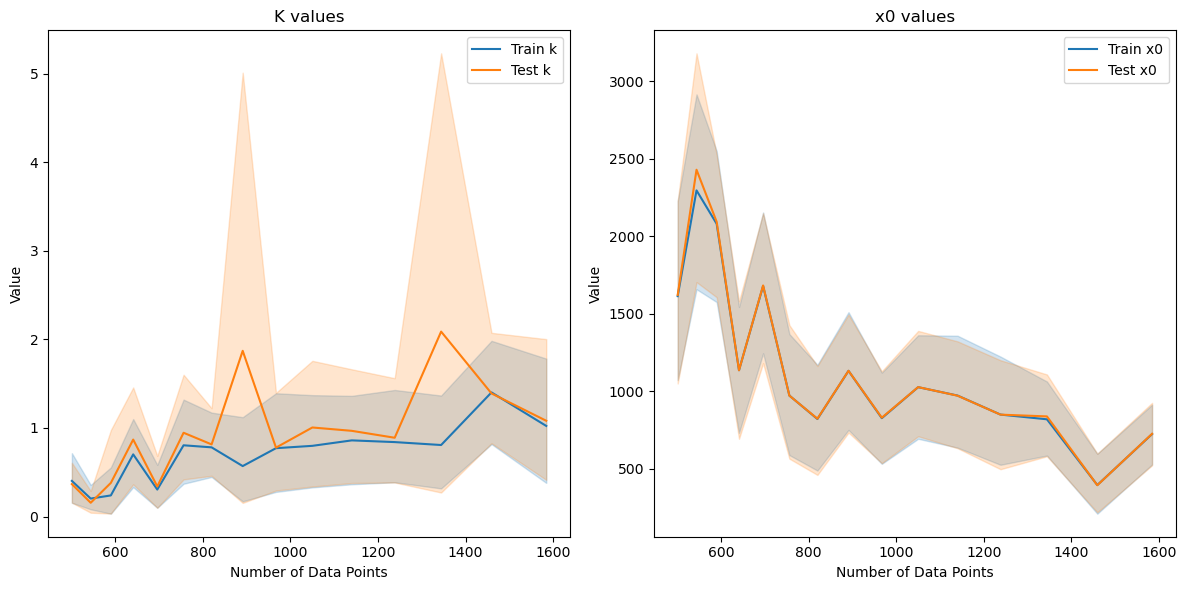

In [131]:
# COPIED: This code is currently identical to code in an above cell, copied here for convenience.

train_sig_params[ train_sig_params==0.0 ] = np.nan
test_sig_params[ test_sig_params==0.0 ] = np.nan

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

#num_samples_list = np.arange(1000, 2000, 10)
repeated_num_samples_list = np.repeat(num_samples_list, repeats = num_repeats)
#print(num_samples_list)
#print(repeated_num_samples_list)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

train_sig_params_k_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'train_sig_params_k': train_sig_params_k})
test_sig_params_k_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'test_sig_params_k': test_sig_params_k})

# Plot train values
sns.lineplot(data=train_sig_params_k_df, x='repeated_num_samples_list', y='train_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Train k')
sns.lineplot(data=test_sig_params_k_df, x='repeated_num_samples_list', y='test_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Test k')

#sns.lineplot(data=train_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Train k'))
#sns.lineplot(data=test_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Test k')

#axs[0].set_xticks(range(len(num_samples_list)))
#axs[0].set_xticklabels(num_samples_list)
axs[0].set_xlabel('Number of Data Points')
axs[0].set_ylabel('Value')
axs[0].set_title('K values')
axs[0].legend()

train_sig_params_x0_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'train_sig_params_x0': train_sig_params_x0})
test_sig_params_x0_df = pd.DataFrame({'repeated_num_samples_list': repeated_num_samples_list, 'test_sig_params_x0': test_sig_params_x0})

# Plot test values
sns.lineplot(data=train_sig_params_x0_df, x='repeated_num_samples_list', y='train_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Train x0')
sns.lineplot(data=test_sig_params_x0_df, x='repeated_num_samples_list', y='test_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Test x0')

#sns.lineplot(data=train_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Train x0')
#sns.lineplot(data=test_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Test x0')

#axs[1].set_xticks(range(len(num_samples_list)))
#axs[1].set_xticklabels(num_samples_list)
axs[1].set_xlabel('Number of Data Points')
axs[1].set_ylabel('Value')
axs[1].set_title('x0 values')
axs[1].legend()

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()

len_message = 10
Repeat: 0 - Epoch: 0 - Test Accuracy: 0.46
Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.533333

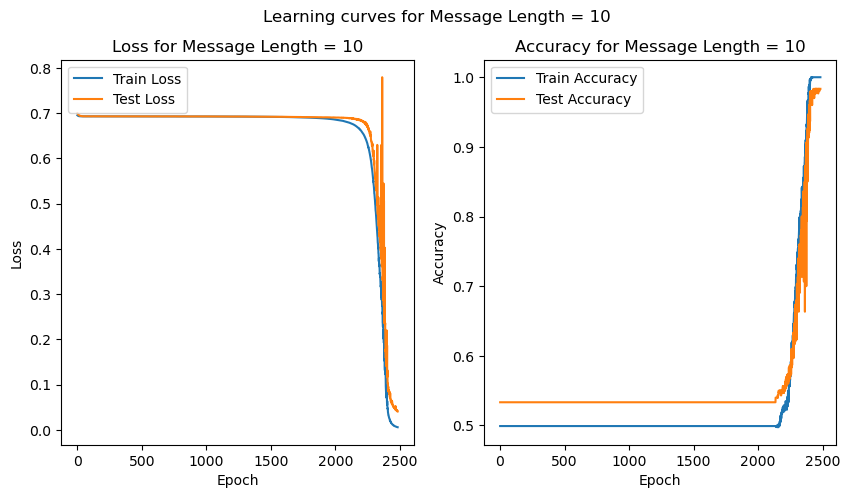

C:\Users\plogo\AppData\Local\Temp\ipykernel_18020\2544603594.py:135: RuntimeWarning: overflow encountered in exp
  y = 0.5 / (1 + np.exp(-k*(x-x0))) + 0.5


Repeat: 1 - Epoch: 0 - Test Accuracy: 0.9833333333333333
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 2000 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 2100 - Test A

Repeat: 6 - Epoch: 400 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1700 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1800 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 1900 - Test Accuracy: 0.47333333333333333
Repeat: 6 - Epoch: 2000 - Test

Repeat: 12 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1800 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 1900 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2000 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2100 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2200 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2300 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2400 - Test Accuracy: 0.51
Repeat: 12 - Epoch: 2500 - Test Accuracy: 0.51
Repeat: 12 - Epoch

Repeat: 18 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 18 - Epoch: 1700 - Test Accuracy: 0.49666666666666665
Repeat: 18 - Epoch: 1800 - Test Accuracy: 0.67
Repeat: 18 - Epoch: 1900 - Test Accuracy: 0.9966666666666667
Repeat: 19 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 19 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.503333333

Repeat: 23 - Epoch: 1700 - Test Accuracy: 0.48
Repeat: 23 - Epoch: 1800 - Test Accuracy: 0.54
Repeat: 23 - Epoch: 1900 - Test Accuracy: 0.55
Repeat: 23 - Epoch: 2000 - Test Accuracy: 0.86
Repeat: 23 - Epoch: 2100 - Test Accuracy: 0.9933333333333333
Repeat: 24 - Epoch: 0 - Test Accuracy: 0.9933333333333333
Repeat: 24 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.

Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1700 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1800 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 1900 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 2000 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 2100 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 2200 - Test Accuracy: 0.5533333333333333
Repeat: 0 - Epoch: 2300 - Test Accuracy: 0.5633333333333334
Repeat: 0 - Epoch: 2400 - Test Accuracy: 0.7566666666666667
Repeat: 0 - Epoch: 2500 - Test Accuracy: 0.9966666666666667


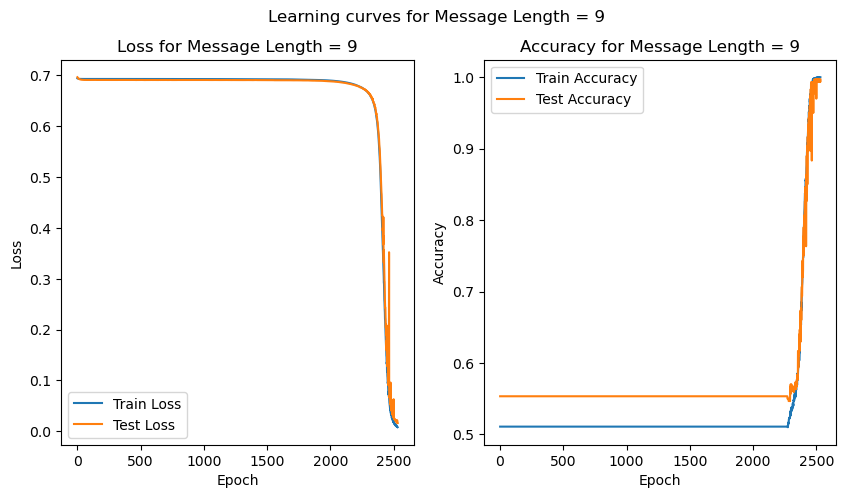

Repeat: 1 - Epoch: 0 - Test Accuracy: 0.9966666666666667
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1800 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 1900 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 2000 - Test Accuracy: 0.51
Repeat: 1 - Epoch: 2100 - Test A

Repeat: 5 - Epoch: 3100 - Test Accuracy: 0.7133333333333334
Repeat: 5 - Epoch: 3200 - Test Accuracy: 0.9866666666666667
Repeat: 6 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 6 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 6 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat:

Repeat: 13 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2000 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2100 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2200 - Test Accuracy: 0.49
Repeat: 13 - Epoch: 2

Repeat: 19 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 19 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1400 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1500 - Test Accuracy: 0.49666666666666665
Repeat: 19 - Epoch: 1600 - Test Accu

Repeat: 24 - Epoch: 200 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1700 - Test Accuracy: 0.4533333333333333
Repeat: 24 - Epoch: 1800 - Test 

Repeat: 29 - Epoch: 1700 - Test Accuracy: 1.0
len_message = 8
Repeat: 0 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 0 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.5333333333333333
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.5333333333333333
Repea

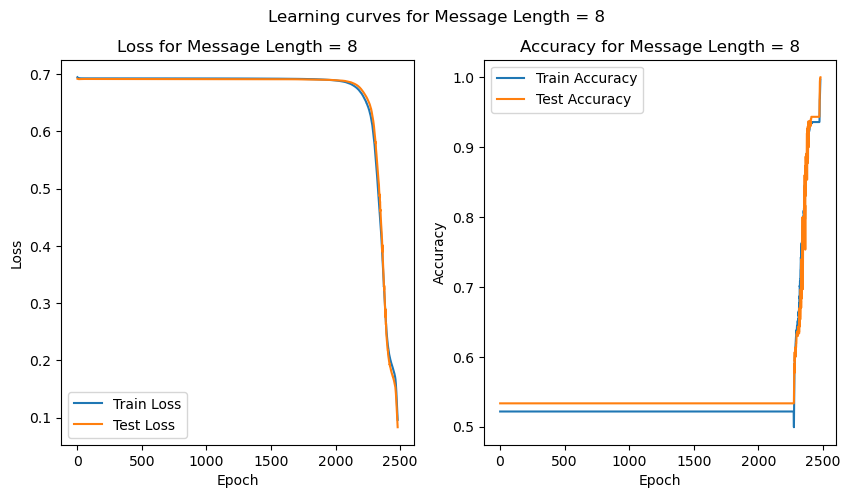

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1800 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 1900 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 2000 - Test Accuracy: 0.49
Repeat: 1 - Epoch: 2100 - Test Accuracy: 0.49
R

Repeat: 6 - Epoch: 3200 - Test Accuracy: 0.5266666666666666
Repeat: 6 - Epoch: 3300 - Test Accuracy: 0.5266666666666666
Repeat: 6 - Epoch: 3400 - Test Accuracy: 0.5266666666666666
Repeat: 6 - Epoch: 3500 - Test Accuracy: 0.5766666666666667
Repeat: 6 - Epoch: 3600 - Test Accuracy: 0.88
Repeat: 6 - Epoch: 3700 - Test Accuracy: 0.9933333333333333
Repeat: 7 - Epoch: 0 - Test Accuracy: 0.9933333333333333
Repeat: 7 - Epoch: 100 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 7 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat

Repeat: 12 - Epoch: 3100 - Test Accuracy: 0.77
Repeat: 12 - Epoch: 3200 - Test Accuracy: 0.9933333333333333
Repeat: 13 - Epoch: 0 - Test Accuracy: 0.9933333333333333
Repeat: 13 - Epoch: 100 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 900 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 1000 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 1100 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 1200 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 1300 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 1400 - Test Accuracy: 0.486666

Repeat: 18 - Epoch: 2600 - Test Accuracy: 0.5133333333333333
Repeat: 18 - Epoch: 2700 - Test Accuracy: 0.5133333333333333
Repeat: 18 - Epoch: 2800 - Test Accuracy: 0.5133333333333333
Repeat: 18 - Epoch: 2900 - Test Accuracy: 0.51
Repeat: 18 - Epoch: 3000 - Test Accuracy: 0.6866666666666666
Repeat: 18 - Epoch: 3100 - Test Accuracy: 0.9966666666666667
Repeat: 19 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 19 - Epoch: 100 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 500 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 600 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 700 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 800 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 900 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 1000 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 1100 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 1200 - Test Accuracy: 0.53
Repeat: 19 - Epoch: 1300 - Test Accuracy: 0.53
Rep

Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1700 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1800 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 1900 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2000 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2100 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2200 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2300 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2400 - Test Accuracy: 0.47333333333333333
Repeat: 24 - Epoch: 2500 - Test Accuracy: 0.6466666666666666
Repeat: 2

Repeat: 0 - Epoch: 100 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 200 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 300 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 400 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 500 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 600 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 700 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 800 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 900 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1000 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1100 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1200 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1300 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 0 - Epoch: 1600 - Test Accuracy: 0.4633333333333333
Repeat: 0 - Epoch: 1700 - Test Acc

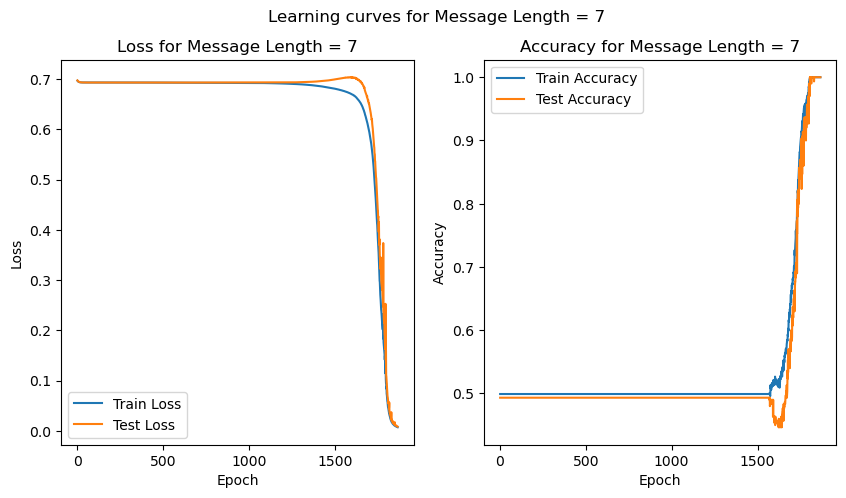

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.54
Repeat: 1 - Epoch: 1700 - Test Accuracy: 0.6566666666666666
Repeat: 1 - Epoch: 1800 - Test Accuracy: 0.8533333333333334
Repeat: 1 - Epoch: 1900 - Test Accuracy: 1.0
Repeat: 2 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 2 - Epoch: 100 -

Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.6533333333333333
Repeat: 9 - Epoch: 1500 - Test Accuracy: 1.0
Repeat: 10 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 10 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.5033333333333333
Repeat: 10 - Epoch: 1400 - Test Accuracy: 0.5033333333333333
Repeat:

Repeat: 16 - Epoch: 800 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 900 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1700 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1800 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 1900 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 2000 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 2100 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 2200 - Test Accuracy: 0.47333333333333333
Repeat: 16 - Epoch: 2300 - Test Accuracy: 0.47333333333333333
Repeat: 16

Repeat: 22 - Epoch: 1400 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1500 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1600 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1700 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1800 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 1900 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 2000 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 2100 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 2200 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 2300 - Test Accuracy: 0.49333333333333335
Repeat: 22 - Epoch: 2400 - Test Accuracy: 0.9433333333333334
Repeat: 23 - Epoch: 0 - Test Accuracy: 0.9633333333333334
Repeat: 23 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 23 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 23 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 23 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 23 - Epoc

Repeat: 28 - Epoch: 1800 - Test Accuracy: 0.52
Repeat: 28 - Epoch: 1900 - Test Accuracy: 0.52
Repeat: 28 - Epoch: 2000 - Test Accuracy: 0.6866666666666666
Repeat: 28 - Epoch: 2100 - Test Accuracy: 0.99
Repeat: 29 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 29 - Epoch: 100 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 200 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 300 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 400 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 500 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 600 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 700 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 800 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 900 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1000 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1100 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1200 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1300 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1400 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1500 - Test Accuracy: 0.46
Repeat: 29 - Epoch: 1600 - Test Accuracy: 0.46
Repeat: 29 -

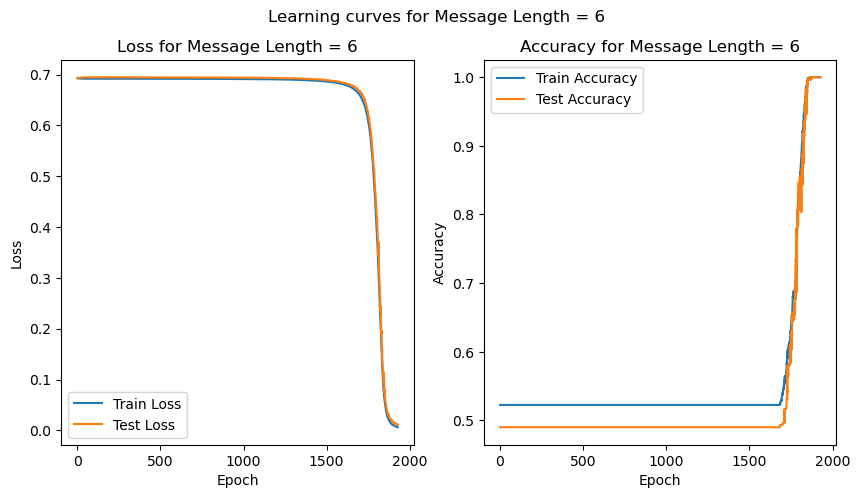

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.5166666666666667
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.5166666666666667
Repeat:

Repeat: 9 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 9 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.52
Repeat: 9 - Epoch: 1700 - Test Accuracy: 0.5333333333333333
Repeat: 9 - Epoch: 1800 - Test Accuracy: 0.6666666666666666
Repeat: 9 - Epoch: 1900 - Test Accuracy: 0.9833333333333333
Repeat: 10 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 

Repeat: 16 - Epoch: 900 - Test Accuracy: 0.5133333333333333
Repeat: 16 - Epoch: 1000 - Test Accuracy: 0.5133333333333333
Repeat: 16 - Epoch: 1100 - Test Accuracy: 0.5133333333333333
Repeat: 16 - Epoch: 1200 - Test Accuracy: 0.5133333333333333
Repeat: 16 - Epoch: 1300 - Test Accuracy: 0.5133333333333333
Repeat: 16 - Epoch: 1400 - Test Accuracy: 0.5233333333333333
Repeat: 16 - Epoch: 1500 - Test Accuracy: 0.7
Repeat: 16 - Epoch: 1600 - Test Accuracy: 0.9866666666666667
Repeat: 17 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 17 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 1000 - Test Accuracy: 0.52
Repeat: 17 - Epoch: 1100

Repeat: 23 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 23 - Epoch: 1400 - Test Accuracy: 0.58
Repeat: 23 - Epoch: 1500 - Test Accuracy: 0.9366666666666666
Repeat: 24 - Epoch: 0 - Test Accuracy: 0.95
Repeat: 24 - Epoch: 100 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 200 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 300 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 400 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 500 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 600 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 700 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 800 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 900 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 1000 - Test Accuracy: 0.48
Repeat: 24 - Epoch: 1100 - Test Accuracy: 0.5966666666666667
Repeat: 24 - Epoch: 1200 - Test Accuracy: 0.7366666666666667
Repeat: 24 - Epoch: 1300 - Test Accuracy: 0.8633333333333333
Repeat: 24 - Epoch: 1400 - Test Accuracy: 0.9733333333333334
Repeat: 25 - Epoch: 0 - Test Accuracy: 0.9866666666666667
Repeat: 25 - Epoch: 100 

Repeat: 0 - Epoch: 2000 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 2100 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 2200 - Test Accuracy: 0.5033333333333333
Repeat: 0 - Epoch: 2300 - Test Accuracy: 0.83
Repeat: 0 - Epoch: 2400 - Test Accuracy: 1.0


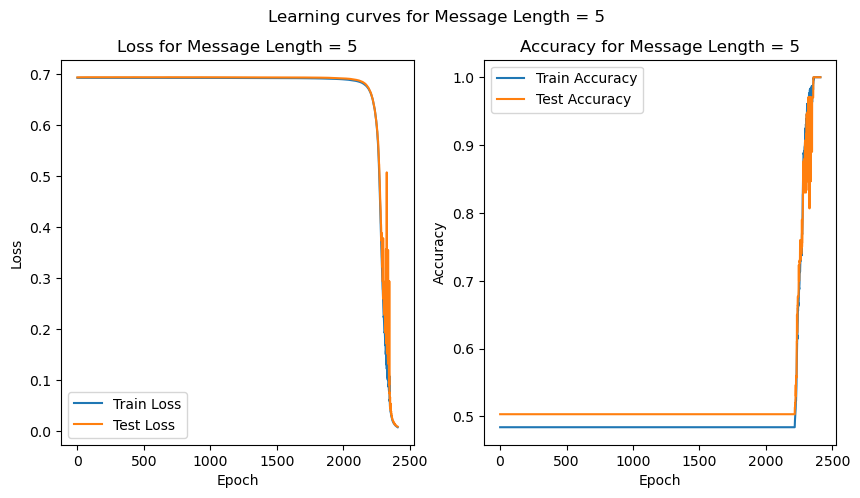

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1200 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1300 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1400 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1500 - Test Accuracy: 0.48333333333333334
Repeat: 1 - Epoch: 1600 - Test Accuracy: 0.483333333

Repeat: 9 - Epoch: 500 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 600 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 700 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 800 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 900 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1000 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1100 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1200 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1300 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1400 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1500 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1600 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1700 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1800 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 1900 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 2000 - Test Accuracy: 0.4533333333333333
Repeat: 9 - Epoch: 2100 - Test Accuracy: 0.45

Repeat: 18 - Epoch: 100 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 200 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.5033333333333333
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.6466666666666666
Repeat: 18 - Epoch: 1200 - Test Accuracy: 1.0
Repeat: 19 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 19 - Epoch: 100 - Test Accuracy: 0.5366666666666666
Repeat: 19 - Epoch: 200 - Test Accuracy: 0.5366666666666666
Repeat: 19 - Epoch: 300 - Test Accuracy: 0.5366666666666666
Repeat: 19 - Epoch: 400 - Test Accuracy: 0.5366666666666666
Repeat: 1

Repeat: 26 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 26 - Epoch: 1400 - Test Accuracy: 0.4866666666666667
Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.7366666666666667
Repeat: 26 - Epoch: 1600 - Test Accuracy: 1.0
Repeat: 27 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 27 - Epoch: 100 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.52
Repeat: 27 

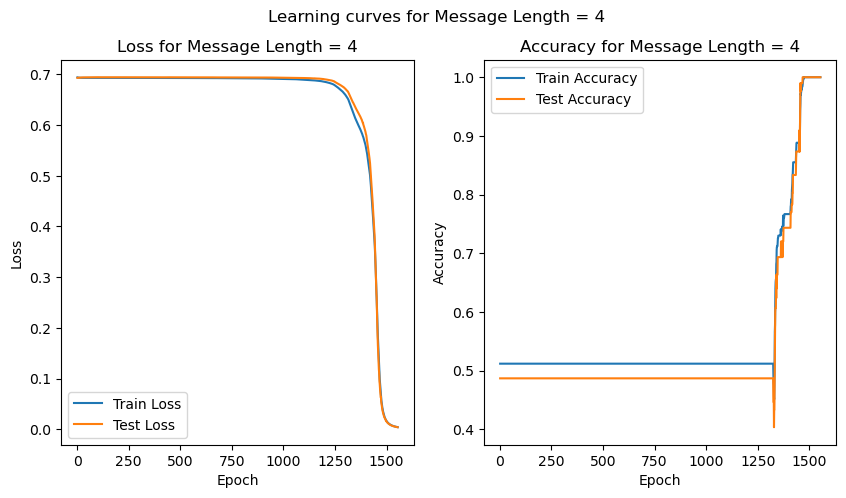

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.49666666666666665
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.9766666666666667
Repeat: 2 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 2 - Epoch: 100 - Test Accuracy: 0.5133333333333333
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.5133333333333333
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.5133333333333333
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.5133333333333333
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.5133333333333333
Repeat: 2 - Epoch: 60

Repeat: 9 - Epoch: 1800 - Test Accuracy: 0.49333333333333335
Repeat: 9 - Epoch: 1900 - Test Accuracy: 0.9766666666666667
Repeat: 10 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 10 - Epoch: 100 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 200 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 300 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 400 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 500 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 600 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 700 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 800 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 900 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 1000 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 1100 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 1200 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 1300 - Test Accuracy: 0.43333333333333335
Repeat: 10 - Epoch: 1400 - Test Accurac

Repeat: 18 - Epoch: 200 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 300 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 400 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 500 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 600 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 700 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 800 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 900 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1000 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1100 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1200 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1300 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1400 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1500 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1600 - Test Accuracy: 0.4766666666666667
Repeat: 18 - Epoch: 1700 - Test Accuracy: 0.9466666666666667
Repeat: 19 - Epoch: 0 - Test Acc

Repeat: 26 - Epoch: 1500 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1600 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1700 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1800 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 1900 - Test Accuracy: 0.46
Repeat: 26 - Epoch: 2000 - Test Accuracy: 1.0
Repeat: 27 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 27 - Epoch: 100 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.5333333333333333
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.5333333333333333
Repeat: 27 - E

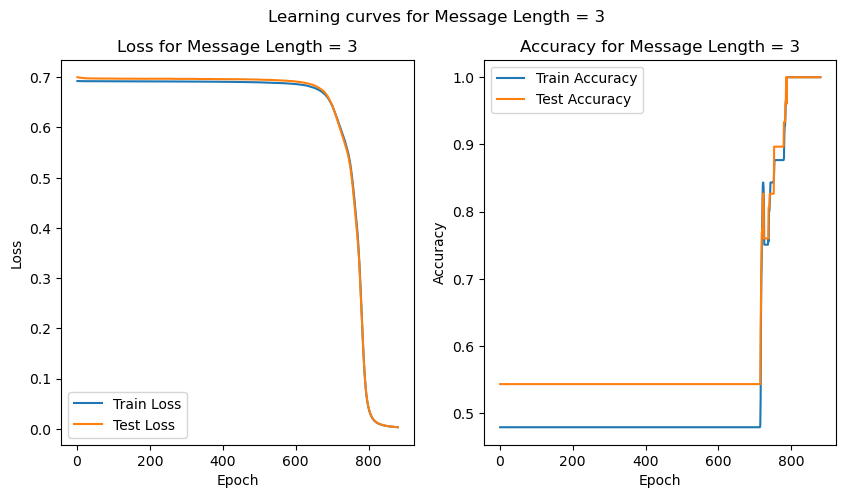

Repeat: 1 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 1 - Epoch: 100 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 200 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 300 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 400 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 500 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 600 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 700 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 800 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 900 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 1000 - Test Accuracy: 0.5266666666666666
Repeat: 1 - Epoch: 1100 - Test Accuracy: 0.81
Repeat: 1 - Epoch: 1200 - Test Accuracy: 1.0
Repeat: 2 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 2 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 2 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 2 - Ep

Repeat: 13 - Epoch: 200 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 300 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 400 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 500 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 600 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 700 - Test Accuracy: 0.4866666666666667
Repeat: 13 - Epoch: 800 - Test Accuracy: 0.52
Repeat: 13 - Epoch: 900 - Test Accuracy: 1.0
Repeat: 14 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 14 - Epoch: 100 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 200 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 300 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 400 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 500 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 600 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 700 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 800 - Test Accuracy: 0.5066666666666667
Repeat: 14 - Epoch: 900 - 

Repeat: 26 - Epoch: 200 - Test Accuracy: 0.5233333333333333
Repeat: 26 - Epoch: 300 - Test Accuracy: 0.5233333333333333
Repeat: 26 - Epoch: 400 - Test Accuracy: 0.5233333333333333
Repeat: 26 - Epoch: 500 - Test Accuracy: 0.5233333333333333
Repeat: 26 - Epoch: 600 - Test Accuracy: 0.5233333333333333
Repeat: 26 - Epoch: 700 - Test Accuracy: 0.9066666666666666
Repeat: 27 - Epoch: 0 - Test Accuracy: 1.0
Repeat: 27 - Epoch: 100 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 200 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 300 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 400 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 500 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 600 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 700 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 800 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 900 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 1000 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 1100 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 1200 - Test Accuracy: 0.5
Repeat: 27 - Epoch: 1300 - Test Accuracy: 1.0
Repeat: 

C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\plogo\anaconda3\envs\cnn\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

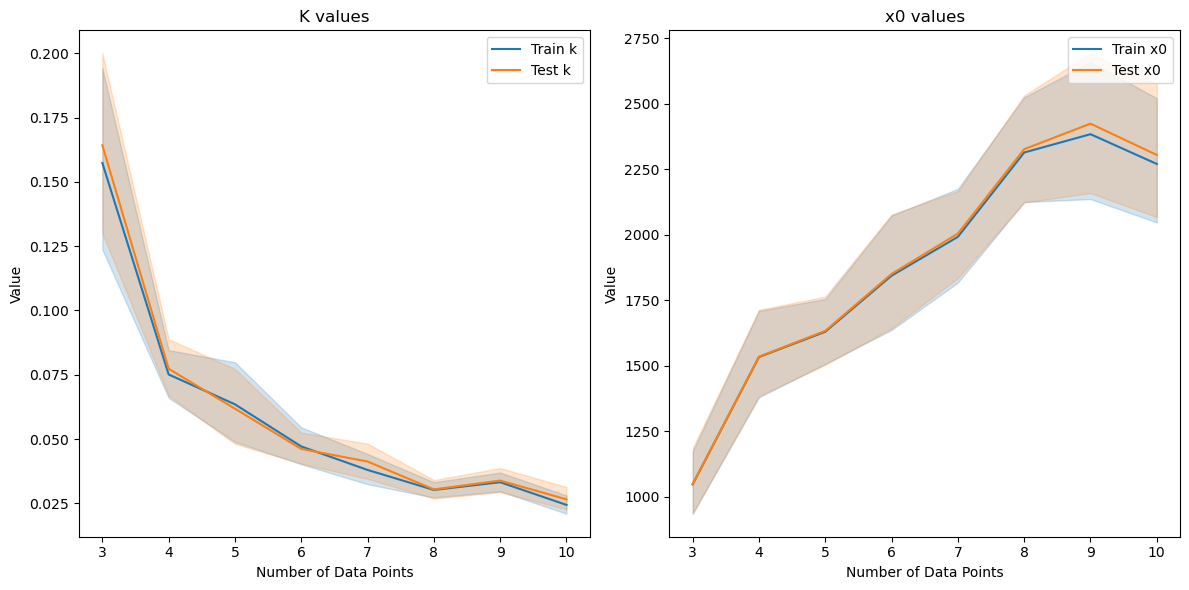

In [28]:
# Modifying prior code, such that it checks against message length rather than number of samples.

# Modifying the above code, such that the training process only halts after 98% or so accuracy is reached
# Using a hard stop to avoid runtime errors, and some later lag to get additional data, 
# this should make the code for efficient

# Find sigmoid fit parameters on average (weighted by covariance error?)

num_repeats = 30

n_tasks = 3
len_taskcode = 8 # length of the code defining the task. This will go at the beginning of each entry
num_checks = 3  # Length of the associated integer list for each task. Must be less than len_message
#len_message_list = np.arange(3,11,1,dtype=int)  # Maximum integer value in the associated integer list
len_message_list = [10, 9, 8, 7, 6, 5, 4, 3]
num_samples = 1500 #possibly not enough
samples_per_task = 1 # Kept at 1 for as long as I do not actually want to check the task performance
# Define hyperparameters
#input_size = len_taskcode + len_message
output_size = 1
learning_rate = 0.005
batch_size = 32

max_num_epochs = 10000 # Probably far too high
epoch_lag = 100 # Not very far at all. Should be just enough to get the grok though. This should be increased I think
accuracy_lim = 0.90

test_frac = 0.2 # proportion of dataset reserved for validation
num_layers = 6
hidden_size = 32

# For sigmoid fits. At the moment arranged for constrained_sigmoid
train_sig_params = np.zeros((len(len_message_list), 2, num_repeats))
test_sig_params = np.zeros((len(len_message_list), 2, num_repeats))

#plt.close()
#fig, axs = plt.subplots(len(hidden_size_list), 2, figsize=(10, len(hidden_size_list)*5))


for index, len_message in enumerate(len_message_list):
    print(f'len_message = {len_message}')
    
    for repeat_idx in range(num_repeats):
        tasks_dict = generate_dict(n_tasks, len_taskcode, num_checks, len_message)

        [data, value] = generate_dataset(tasks_dict, num_samples)

        # Create a dataframe for training
        df = pd.DataFrame(np.concatenate((data, value.reshape(-1, 1)), axis=1), columns=[f'feature_{i}' for i in range(len_taskcode + len_message)] + ['target'])

        # Split the data into training and test sets
        train_df, test_df = train_test_split(df, test_size=test_frac, random_state=42)

        # Create instances of the neural network
        input_size = len_taskcode + len_message
        model = NeuralNetwork(input_size, output_size, num_layers, hidden_size)

        # Define loss function and optimizer (same as before)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)

        # Create DataLoaders for the training and test data
        train_dataset = CustomDataset(train_df)
        test_dataset = CustomDataset(test_df)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        train_loss_list = np.empty(max_num_epochs)
        test_loss_list = np.empty(max_num_epochs)

        train_accuracy_list = np.empty(max_num_epochs)
        test_accuracy_list = np.empty(max_num_epochs)

        accuracy_array = np.zeros((n_tasks, max_num_epochs)) # such that each row is the accuracy for that specific task over all epochs

        # Train the model
        lag_counter = 0
        epoch = 0
        #pbar = tqdm(total=max_num_epochs)
        while lag_counter <= epoch_lag and epoch <= max_num_epochs:
            
            train_loss = 0.0
            train_correct = 0
            train_total = 0
            model.train()
            
            if epoch % 100 == 0:
                print(f'Repeat: {repeat_idx} - Epoch: {epoch} - Test Accuracy: {test_accuracy}')

            for inputs, labels in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels.unsqueeze(1))

                # Compute predictions
                predictions = (outputs >= 0.5).squeeze().long()

                # Compute accuracy
                train_correct += (predictions == labels).sum().item()
                train_total += labels.size(0)

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * inputs.size(0)

            # Calculate average train loss
            train_loss = train_loss / len(train_dataset)
            # Calculate average train accuracy
            train_accuracy = train_correct / train_total

            # Evaluate the model on the test set
            model.eval()
            test_loss = 0.0
            test_correct = 0
            test_total = 0

            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    # Compute predictions
                    predictions = (outputs >= 0.5).squeeze().long()

                    # Compute accuracy
                    test_correct += (predictions == labels).sum().item()
                    test_total += labels.size(0)

                    loss = criterion(outputs, labels.unsqueeze(1))
                    test_loss += loss.item() * inputs.size(0)

                # Calculate average test loss
                test_loss = test_loss / len(test_dataset)

            # Calculate average test accuracy
            test_accuracy = test_correct / test_total
            
            if test_accuracy > accuracy_lim:
                lag_counter += 1

            # Update the loss lists
            train_loss_list[epoch] = train_loss
            test_loss_list[epoch] = test_loss

            train_accuracy_list[epoch] = train_accuracy
            test_accuracy_list[epoch] = test_accuracy
            
            epoch += 1
            #pbar.update(1)
        #pbar.close() # dealing with progress bar
        num_epochs = epoch # redefining the maximum extent of the x axis in plots to however far the algorithm went.
        
        # truncating loss and accuracy data, removing excess zeros at the ends
        train_loss_list = train_loss_list[0:epoch]
        test_loss_list = test_loss_list[0:epoch]
        train_accuracy_list = train_accuracy_list[0:epoch]
        test_accuracy_list = test_accuracy_list[0:epoch]
        
        if repeat_idx == 0: 
            # Create subplots with 1 row and 2 columns
            fig, axs = plt.subplots(1, 2, figsize=(10, 5))

            pytorch_total_params = sum(p.numel() for p in model.parameters())
            #print(f"Total model parameters = {pytorch_total_params}")
            
            # Plot the training and test losses on the first subplot
            axs[0].plot(range(1, num_epochs+1), train_loss_list, label='Train Loss')
            axs[0].plot(range(1, num_epochs+1), test_loss_list, label='Test Loss')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Loss')
            axs[0].legend()
            axs[0].set_title(f'Loss for Message Length = {len_message}')  # Set title for the first subplot

            # Plot the training and test accuracies on the second subplot
            axs[1].plot(range(1, num_epochs+1), train_accuracy_list, label='Train Accuracy')
            axs[1].plot(range(1, num_epochs+1), test_accuracy_list, label='Test Accuracy')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Accuracy')
            axs[1].legend()
            axs[1].set_title(f'Accuracy for Message Length = {len_message}')

            plt.suptitle(f'Learning curves for Message Length = {len_message}', y=0.98)
            plt.show()
        #pbar.close()
        # Used when constrained sigmoid function is being fit
        epoch_list = range(1, num_epochs+1)
        try:
            p0_train = [np.median(epoch_list) , 1] # this is an mandatory initial guess
            popt_train, pcov_train = curve_fit(constrained_sigmoid, epoch_list, train_accuracy_list, p0_train, method='dogbox')
            p0_test = [np.median(epoch_list) , 1]
            popt_test, pcov_test = curve_fit(constrained_sigmoid, epoch_list, test_accuracy_list, p0_test, method='dogbox')

            train_accuracy_fit = constrained_sigmoid(epoch_list, popt_train[0], popt_train[1])
            test_accuracy_fit = constrained_sigmoid(epoch_list, popt_test[0], popt_test[1])

            #plt.plot(epoch_list, train_accuracy_fit, label='Sigmoid fit - train data')
            #plt.plot(epoch_list, test_accuracy_fit, label='Sigmoid fit - test data')
            #plt.legend()
            #plt.show()

            train_sig_params[index, :, repeat_idx] = popt_train
            test_sig_params[index, :, repeat_idx] = popt_test

        except RuntimeError:
            print('Failed to find optimal solution')
    
print('train_sig_params = ', train_sig_params) # x0, k
print('test_sig_params = ', test_sig_params) # x0, k

train_sig_params_copy = train_sig_params
test_sig_params_copy = test_sig_params

# COPIED: This code is currently identical to code in an above cell, copied here for convenience.

train_sig_params[ train_sig_params==0.0 ] = np.nan
test_sig_params[ test_sig_params==0.0 ] = np.nan

train_sig_params_x0 = train_sig_params[:, 0, :].flatten()
train_sig_params_k = train_sig_params[:, 1, :].flatten()

test_sig_params_x0 = test_sig_params[:, 0, :].flatten()
test_sig_params_k = test_sig_params[:, 1, :].flatten()

#num_samples_list = np.arange(1000, 2000, 10)
repeated_len_message_list = np.repeat(len_message_list, repeats = num_repeats)
#print(num_samples_list)
#print(repeated_num_samples_list)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

train_sig_params_k_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'train_sig_params_k': train_sig_params_k})
test_sig_params_k_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'test_sig_params_k': test_sig_params_k})

# Plot train values
sns.lineplot(data=train_sig_params_k_df, x='repeated_len_message_list', y='train_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Train k')
sns.lineplot(data=test_sig_params_k_df, x='repeated_len_message_list', y='test_sig_params_k', ax=axs[0], errorbar=('ci', 95), label='Test k')

#sns.lineplot(data=train_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Train k'))
#sns.lineplot(data=test_sig_params_k, ax=axs[0], errorbar=('ci', 95), label='Test k')

#axs[0].set_xticks(range(len(num_samples_list)))
#axs[0].set_xticklabels(num_samples_list)
axs[0].set_xlabel('Number of Data Points')
axs[0].set_ylabel('Value')
axs[0].set_title('K values')
axs[0].legend()

train_sig_params_x0_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'train_sig_params_x0': train_sig_params_x0})
test_sig_params_x0_df = pd.DataFrame({'repeated_len_message_list': repeated_len_message_list, 'test_sig_params_x0': test_sig_params_x0})

# Plot test values
sns.lineplot(data=train_sig_params_x0_df, x='repeated_len_message_list', y='train_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Train x0')
sns.lineplot(data=test_sig_params_x0_df, x='repeated_len_message_list', y='test_sig_params_x0', ax=axs[1], errorbar=('ci', 95), label='Test x0')

#sns.lineplot(data=train_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Train x0')
#sns.lineplot(data=test_sig_params_x0, ax=axs[1], errorbar=('ci', 95), label='Test x0')

#axs[1].set_xticks(range(len(num_samples_list)))
#axs[1].set_xticklabels(num_samples_list)
axs[1].set_xlabel('Number of Data Points')
axs[1].set_ylabel('Value')
axs[1].set_title('x0 values')
axs[1].legend()

# Adjust the layout of subplots
plt.tight_layout()

# Display the plot
plt.show()